Dataset overview:
<class 'pandas.core.frame.DataFrame'>
Index: 39126 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39126 non-null  object
 1   receiver  39126 non-null  object
 2   date      39126 non-null  object
 3   subject   39126 non-null  object
 4   body      39126 non-null  object
 5   label     39126 non-null  int64 
 6   urls      39126 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.4+ MB

Sample data:
                                               sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@g

C:\Users\jeffr\AppData\Local\Temp\ipykernel_14604\117012876.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


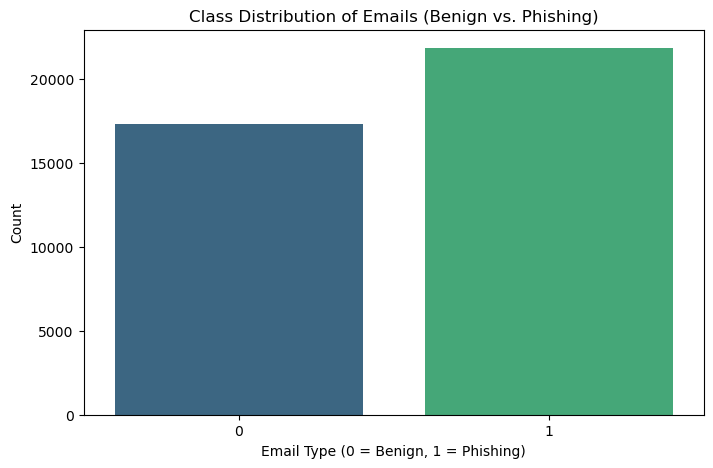

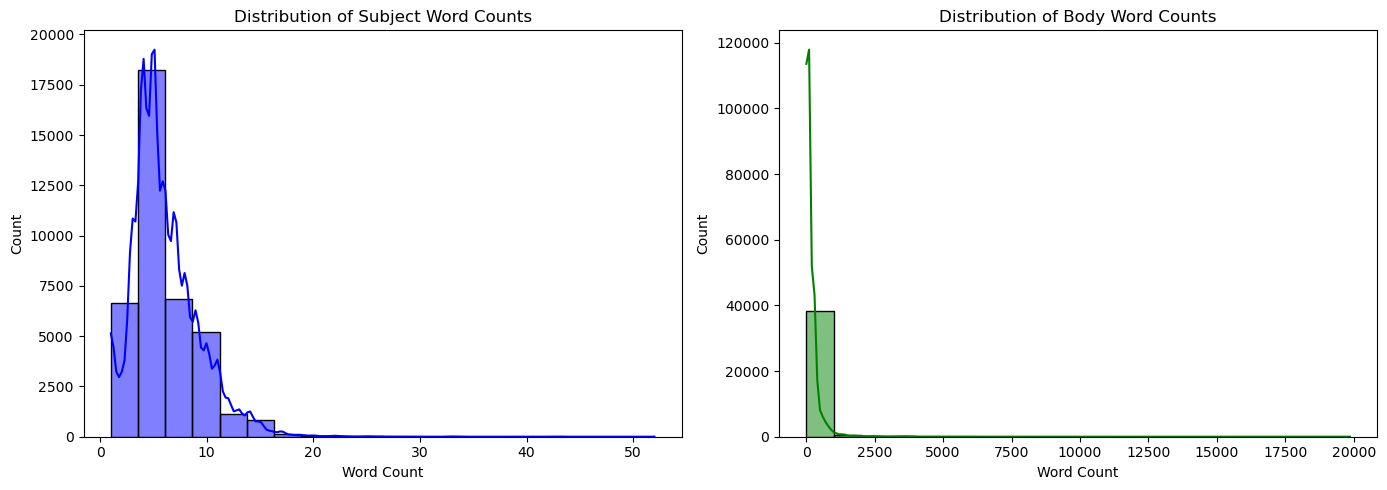

Decision Tree Evaluation:
              precision    recall  f1-score   support

  Benign (0)       0.99      0.97      0.98      3506
Phishing (1)       0.98      0.99      0.98      4320

    accuracy                           0.98      7826
   macro avg       0.98      0.98      0.98      7826
weighted avg       0.98      0.98      0.98      7826


Random Forest Evaluation:
              precision    recall  f1-score   support

  Benign (0)       0.99      0.98      0.99      3506
Phishing (1)       0.98      0.99      0.99      4320

    accuracy                           0.99      7826
   macro avg       0.99      0.99      0.99      7826
weighted avg       0.99      0.99      0.99      7826


Optimized Random Forest Evaluation:
              precision    recall  f1-score   support

  Benign (0)       1.00      0.77      0.87      3506
Phishing (1)       0.84      1.00      0.91      4320

    accuracy                           0.89      7826
   macro avg       0.92      0.88     

C:\Users\jeffr\AppData\Local\Temp\ipykernel_14604\117012876.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=execution_times, palette="viridis")


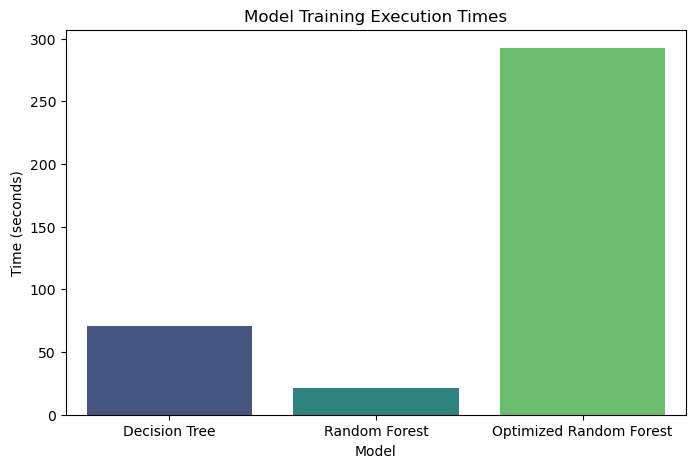

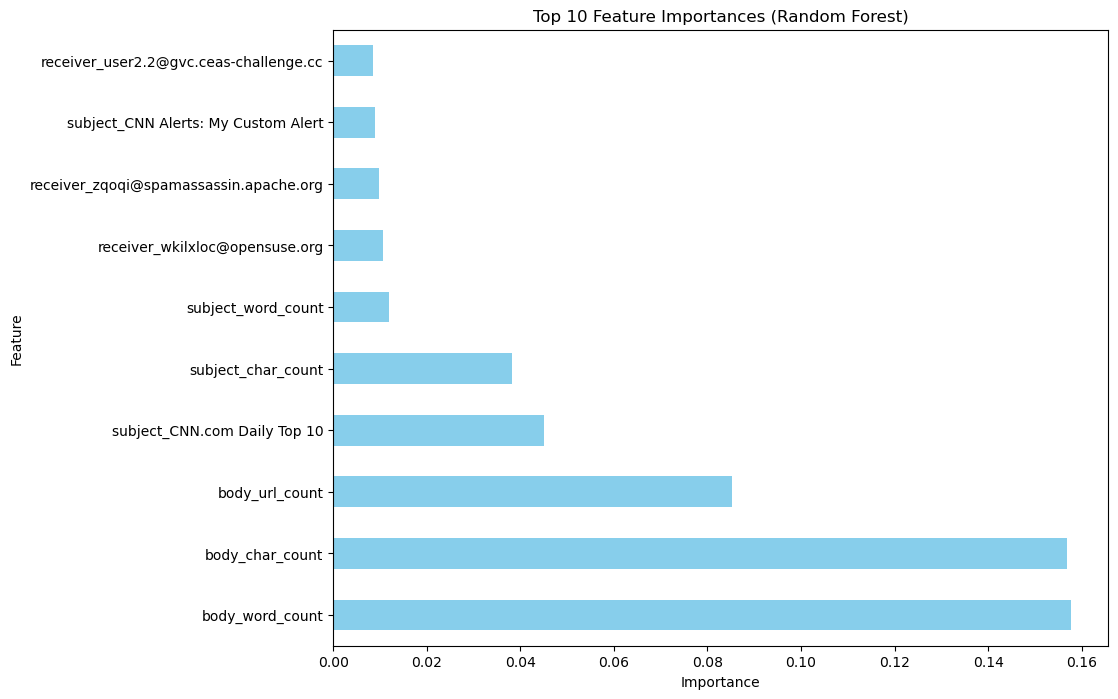

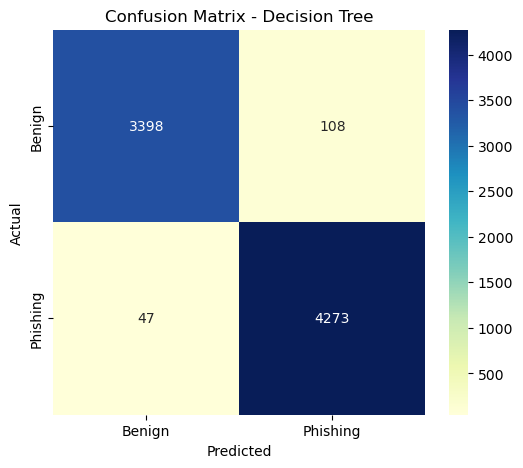

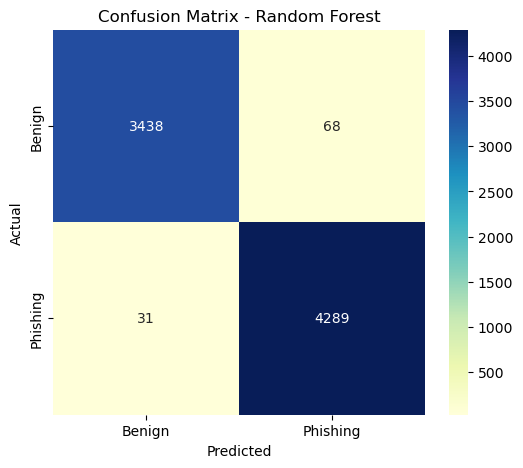

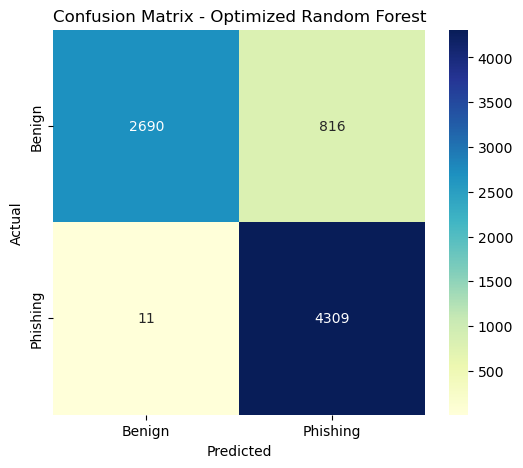


Summary of Model Performance:
Decision Tree Accuracy: 0.9802
Random Forest Accuracy: 0.9873
Optimized Random Forest Accuracy: 0.8943


In [ ]:
#Jeffrey Franks 100784373
#Sadra Keshavarzsafiei 10081858

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time

# Load phishing dataset 
data = pd.read_csv("phishing_email.csv")

# Drop rows with missing values in essential columns
data = data.dropna(subset=['sender', 'subject', 'body', 'label'])

# Fill non-essential missing text data with 'Unknown'
data['receiver'] = data['receiver'].fillna('Unknown')


# Display dataset info to check structure
print("Dataset overview:")
data.info()
print("\nSample data:\n", data.head())

# Show the total number of observations in the dataset
print(f"\nTotal observations in dataset: {data.shape[0]}")



# Define data preprocessing function to remove missing and duplicate entries
def preprocess_data(data):
    # Remove empty columns and duplicate rows
    data_cleaned = data.dropna().drop_duplicates()
    
    # Convert target column 'label' to integer type for model compatibility
    data_cleaned['label'] = data_cleaned['label'].astype(int)
    
    return data_cleaned

# Clean the data
data = preprocess_data(data)

# Show class distribution for target label
print("\nClass distribution:\n", data['label'].value_counts())

# Drop the 'date' column as it will be ignored
data = data.drop(columns=['date'])

# Function to process text data (subject and body)
def text_features(data):
    # Create new features for 'subject' and 'body' text
    data['subject_word_count'] = data['subject'].apply(lambda x: len(str(x).split()))
    data['body_word_count'] = data['body'].apply(lambda x: len(str(x).split()))
    data['subject_char_count'] = data['subject'].apply(lambda x: len(str(x)))
    data['body_char_count'] = data['body'].apply(lambda x: len(str(x)))
    data['subject_url_count'] = data['subject'].apply(lambda x: x.lower().count('http') + x.lower().count('www'))
    data['body_url_count'] = data['body'].apply(lambda x: x.lower().count('http') + x.lower().count('www'))
    
    return data

# Process the text features
data = text_features(data)

# One-hot encode the 'sender', 'receiver', and 'subject' columns
data = pd.get_dummies(data, columns=['sender', 'receiver', 'subject'], drop_first=True)

# Splitting dataset into features (X) and target (y)
X = data.drop(columns=['label', 'body'])  # Drop 'body' after processing
y = data['label']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette="viridis")
plt.title("Class Distribution of Emails (Benign vs. Phishing)")
plt.xlabel("Email Type (0 = Benign, 1 = Phishing)")
plt.ylabel("Count")
plt.show()

# Plot word and character count distributions
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['subject_word_count'], bins=20, kde=True, color='blue')
plt.title("Distribution of Subject Word Counts")
plt.xlabel("Word Count")

plt.subplot(1, 2, 2)
sns.histplot(data['body_word_count'], bins=20, kde=True, color='green')
plt.title("Distribution of Body Word Counts")
plt.xlabel("Word Count")
plt.tight_layout()
plt.show()

# Function to train a Decision Tree model and record time
def train_decision_tree(X_train, y_train):
    start_time = time.time()
    dt_model = DecisionTreeClassifier(random_state=1)
    dt_model.fit(X_train, y_train)
    end_time = time.time()
    return dt_model, end_time - start_time

# Function to train a Random Forest model and record time
def train_random_forest(X_train, y_train):
    start_time = time.time()
    rf_model = RandomForestClassifier(n_estimators=10, random_state=1)
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    return rf_model, end_time - start_time

# Train models and record execution times
dt_model, dt_time = train_decision_tree(X_train, y_train)
rf_model, rf_time = train_random_forest(X_train, y_train)

# Function for evaluating model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=["Benign (0)", "Phishing (1)"])
    print(report)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

# Evaluate Decision Tree model
print("Decision Tree Evaluation:")
dt_accuracy, dt_pred = evaluate_model(dt_model, X_test, y_test)

# Evaluate Random Forest model
print("\nRandom Forest Evaluation:")
rf_accuracy, rf_pred = evaluate_model(rf_model, X_test, y_test)

# Set hyperparameters for Random Forest model tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20]
}

# Apply GridSearchCV for tuning (uses RandomForest model as in prior code)
start_time = time.time()
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)
end_time = time.time()
opt_rf_time = end_time - start_time

# Retrieve the best model after tuning
best_rf_model = grid_search.best_estimator_

# Evaluate the optimized model on test data
print("\nOptimized Random Forest Evaluation:")
opt_rf_accuracy, opt_rf_pred = evaluate_model(best_rf_model, X_test, y_test)

# Plot model execution times
execution_times = [dt_time, rf_time, opt_rf_time]
models = ['Decision Tree', 'Random Forest', 'Optimized Random Forest']
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=execution_times, palette="viridis")
plt.title("Model Training Execution Times")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.show()

# Plot feature importance for the Random Forest model
plt.figure(figsize=(10, 8))
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Plot confusion matrices for each model
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Benign", "Phishing"], yticklabels=["Benign", "Phishing"])
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Confusion matrix for Decision Tree
plot_confusion_matrix(y_test, dt_pred, "Decision Tree")

# Confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf_pred, "Random Forest")

# Confusion matrix for Optimized Random Forest
plot_confusion_matrix(y_test, opt_rf_pred, "Optimized Random Forest")

# Summarize and compare model performance
print("\nSummary of Model Performance:")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Optimized Random Forest Accuracy: {opt_rf_accuracy:.4f}")
